In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

# set gpu as default device
torch.set_default_device("cuda")

## Models

In [7]:
class RidgeRegressor(nn.Module):
    def __init__(self, noise_variance: float = 0.0):
        super().__init__()
        self.noise_variance = noise_variance

    def forward(self, X, y):
        # print("Zdebug", X.shape, y.shape)
        n_samples, n_dim = X.shape
        ones = torch.ones(n_samples, 1, device=X.device)
        X = torch.concat([X, ones], dim=-1) # add bias

        if n_samples >= n_dim:
            # standard
            A = X.T@X
            A.diagonal().add_(self.noise_variance)
            B = X.T@y
            weights = torch.linalg.solve(A, B)
        else:
            # Woodbury
            A = X@X.T
            A.diagonal().add_(self.noise_variance)
            weights = X.T@torch.linalg.solve(A, y)
            
        w = weights[:-1].reshape(-1, 1)
        b = weights[-1].reshape(1, 1)

        return w, b # (n_dim, 1), (1, 1)

class SIREN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layers: list, activation_scale: float, dropout: float):
        super().__init__()

        self.activation_scale = activation_scale
        self.dropout = dropout

        self.input_layer = nn.Linear(input_dim, layers[0])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out

def get_initialized_model(input_dim, output_dim, layers, activation_scale, dropout):
    def first_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-1 / input_size, 1 / input_size)

    def other_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-np.sqrt(6 / input_size) / activation_scale, np.sqrt(6 / input_size) / activation_scale)

    model = SIREN(input_dim, output_dim, layers, activation_scale, dropout)
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

    return model

## Data generation

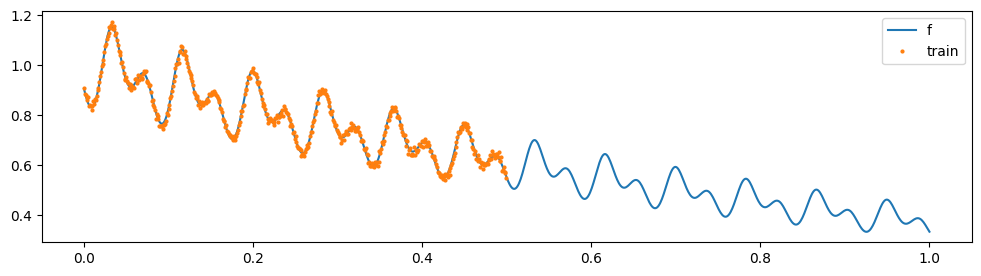

In [8]:
N = 1000
x_all = torch.linspace(0, 1, N).reshape(-1, 1)
f = lambda x: torch.exp(-(torch.sin(48 * np.pi * x) + torch.cos(24 * np.pi * x) + 10*x)/10)
# f = lambda x: x ** 2 
# f = lambda x: torch.log(x)
# a non-smooth degree 5 polynomial function
# f = lambda x: 0.01 * x ** 5 - 0.2 * x ** 3 - x + 0.5

x_train = x_all[:N//2]
noise_std = 0.01
y_train = f(x_train) + noise_std * torch.randn(N//2, 1)

x_test = x_all[N//2:]

plt.figure(figsize=(12, 3))
plt.plot(x_all.cpu(), f(x_all).cpu(), label='f');
plt.plot(x_train.cpu(), y_train.cpu(), 'o', label='train', markersize=2);
plt.legend();

## Data sequence preperation

In [9]:
lookback_window = 64*3
lookahead_window = 64*2
randomize = True

x_context = []
y_context = []
x_target = []
y_target = []
if randomize:
    indices = torch.randperm(lookback_window+lookahead_window)
for i in range(lookback_window, len(x_train)-lookahead_window+1):
    x = torch.linspace(0, 1, lookahead_window+lookback_window).reshape(-1, 1)
    y = y_train[i-lookback_window:i+lookahead_window]
    x = x[indices]
    y = y[indices]
    
    x_context.append(x[:lookback_window][np.newaxis, ...])
    x_target.append(x[-lookahead_window:][np.newaxis, ...])
    
    y_context.append(y[:lookback_window][np.newaxis, ...])
    y_target.append(y[-lookahead_window:][np.newaxis, ...])

x_context = torch.cat(x_context, dim=0)
x_target = torch.cat(x_target, dim=0)
y_context = torch.cat(y_context, dim=0)
y_target = torch.cat(y_target, dim=0)
print(f"{x_context.shape=}, \n{x_target.shape=}") # [lookback_window, 1], [lookahead_window, 1]
print(f"{y_context.shape=}, \n{y_target.shape=}") # [N, lookback_window, 1], [N, lookahead_window, 1]

x_context.shape=torch.Size([181, 192, 1]), 
x_target.shape=torch.Size([181, 128, 1])
y_context.shape=torch.Size([181, 192, 1]), 
y_target.shape=torch.Size([181, 128, 1])


## Training

In [10]:
from albk.torch.models import MLP

Loss: 0.0001: 100%|██████████| 500/500 [00:03<00:00, 141.59it/s]


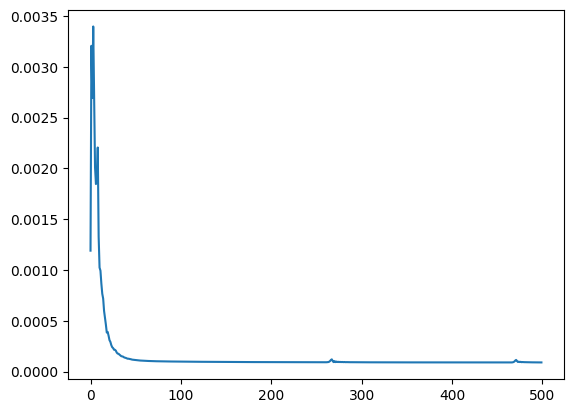

In [11]:
siren = get_initialized_model(1, 16, [256, 256], 30.0, 0.0)
# siren = MLP(1, 16, [256, 256], activation="relu")
ridge_reg = RidgeRegressor(noise_variance=1e-4)

def one_example_forward_pass(x_in, y_in, x_out, mode): # y_input: (lookback_window, 1), y_output: (lookahead_window, 1)
    if mode == "train":
        siren.train()
        ridge_reg.train()
        
    else:
        siren.eval()
        ridge_reg.eval()
        
    time_in = siren(x_in)
    time_out = siren(x_out)

    # print("Zdebug", time_in.shape, y_in.shape)
    w, b = ridge_reg(time_in, y_in)
    y_out_pred = time_out@w + b
    
    return y_out_pred
# forward_pass = torch.vmap(one_example_forward_pass, in_dims=(0, 0, 0, None), out_dims=0, randomness="different")


def one_example_loss_fn(x_context, y_context, x_target, y_target):
    y_out_pred = one_example_forward_pass(x_context, y_context, x_target, "train")
    loss = F.mse_loss(y_out_pred, y_target)
    return loss

loss_fn = torch.vmap(one_example_loss_fn, in_dims=(0, 0, 0, 0), out_dims=0, randomness="different")

optimizer = torch.optim.Adam(siren.parameters(), lr=1e-3)
epochs = 500

pbar = tqdm(range(epochs))
losses = []

for i in pbar:
    optimizer.zero_grad()
    loss = loss_fn(x_context, y_context, x_target, y_target).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f'Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
plt.plot(losses)

## Testing

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([320, 1])
torch.Size([447, 1])


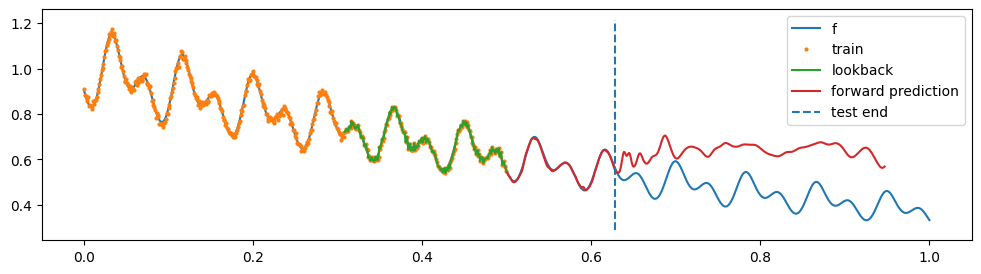

In [12]:
print(x_train.shape, y_train.shape, x.shape)
with torch.no_grad():
    coords = torch.linspace(0, 1, lookback_window + lookahead_window).reshape(-1, 1)
    x_in = coords[:lookback_window]
    x_out = coords[-lookahead_window:]
    x_out = torch.arange(x_out[0].item(), 2.0, x_out[1].item() - x_out[0].item()).reshape(-1, 1)
    y_pred = one_example_forward_pass(x_in, y_train[-lookback_window:], x_out, mode="test")
    print(y_pred.shape)

additiona_length = len(x_out) - lookahead_window

plt.figure(figsize=(12, 3))
plt.plot(x_all.cpu(), f(x_all).cpu(), label="f")
plt.plot(x_train.cpu(), y_train.cpu(), "o", label="train", markersize=2)
plt.plot(x_train[-lookback_window:].cpu(), y_train[-lookback_window:].cpu(), label="lookback")
plt.plot(x_test.cpu()[: lookahead_window + additiona_length], y_pred.cpu(), label="forward prediction")
plt.vlines(x_test[lookahead_window].item(), *plt.gca().get_ylim(), label="test end", linestyles="dashed")
plt.legend()

Deep Time

\begin{align}
    \phi(x_{context}) &= \text{siren}(x_{context}) \\
    \phi(x_{target}) &= \text{siren}(x_{target}) \\
    W &= (\phi(x_{context})^T \phi(x_{context}))^{-1} \phi(x_{context})^T \boldsymbol{y}_{context} \\
    y_{pred} &= \phi(x_{target}) W
\end{align}

## Approximate a 1D GP

torch.Size([100, 1]) torch.Size([100, 100])


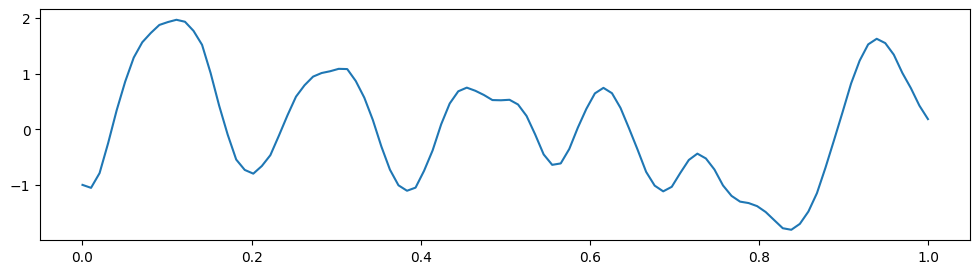

In [13]:
def rbf_function(x1, x2):
    return torch.exp(-torch.cdist(x1, x2)**2/0.05**2)

N = 100
n_samples = 100
x_all = torch.linspace(0, 1, N).reshape(-1, 1)
K = rbf_function(x_all, x_all)
K.diagonal().add_(1e-4)
L = torch.linalg.cholesky(K)
y_all = L@torch.randn(N, n_samples) + 0.01 * torch.randn(N, n_samples)
# y_all = y_all + torch.randn(N, 1) * 0.01

print(x_all.shape, y_all.shape)

plt.figure(figsize=(12, 3))
plt.plot(x_all.cpu(), y_all.cpu()[:, 0], label="f");

Loss: 0.0006: 100%|██████████| 1000/1000 [00:09<00:00, 109.61it/s]


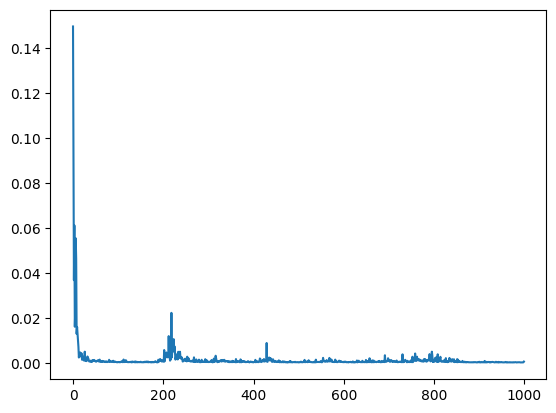

In [21]:
siren = get_initialized_model(1, 32, [256, 256, 256, 256], 30.0, 0.0)
ridge_reg = RidgeRegressor(noise_variance=1e-3)

optimizer = torch.optim.Adam(siren.parameters(), lr=1e-5)
epochs = 1000

pbar = tqdm(range(epochs))
losses = []

for i in pbar:
    idx = torch.randperm(N)
    x_context = x_all[idx][:N//2][np.newaxis, ...]
    y_context = y_all[idx][:N//2][np.newaxis, ...].permute(2, 1, 0)
    x_context = x_context.repeat(n_samples, 1, 1)

    x_target = x_all[idx][N//2:][np.newaxis, ...]
    y_target = y_all[idx][N//2:][np.newaxis, ...].permute(2, 1, 0)
    x_target = x_target.repeat(n_samples, 1, 1)
    # print(x_context.shape, y_context.shape, x_target.shape, y_target.shape)
    optimizer.zero_grad()
    loss = loss_fn(x_context, y_context, x_target, y_target).mean()
    loss.backward()
    optimizer.step()
    pbar.set_description(f'Loss: {loss.item():.4f}')
    losses.append(loss.item())
    
plt.plot(losses)

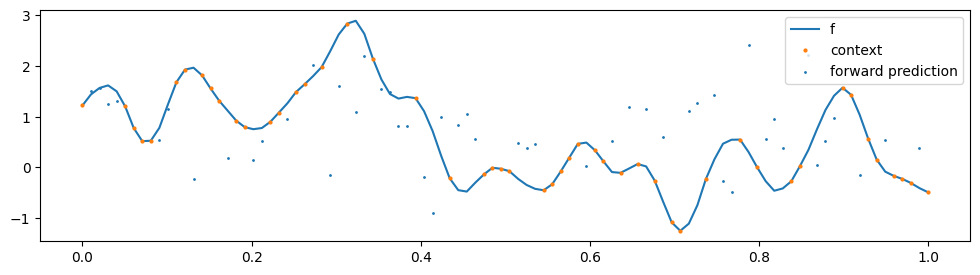

In [22]:
i = 0
y_all = L@torch.randn(N, 1) + 0.01 * torch.randn(N, n_samples)
idx = torch.randperm(N)
# idx = torch.arange(N)

x_context = x_all[idx][:N//2][np.newaxis, ...]
x_target = x_all[idx][N//2:][np.newaxis, ...]
y_context = y_all[idx][:N//2][np.newaxis, ...].permute(2, 1, 0)
y_target = y_all[idx][N//2:][np.newaxis, ...].permute(2, 1, 0)

with torch.no_grad():
    y_out = one_example_forward_pass(x_context[i], y_context[i], y_target[i], mode="test")
    
plt.figure(figsize=(12, 3))
plt.plot(x_all.cpu(), y_all.cpu()[:, i], label="f");
plt.plot(x_context[i].cpu(), y_context[i].cpu(), "o", label="context", markersize=2)
plt.scatter(x_target[i].cpu(), y_out.cpu(), label="forward prediction", s=1)
plt.legend();

## Appendix

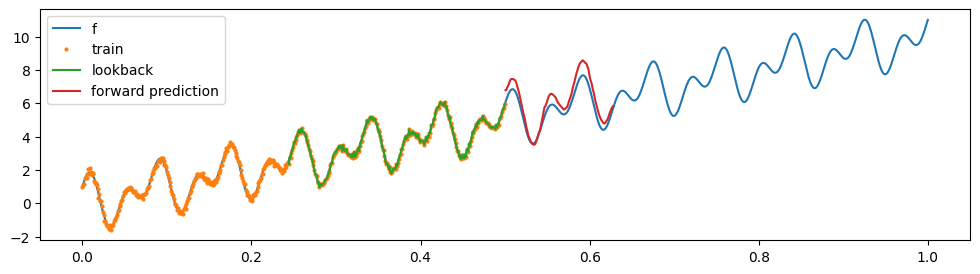

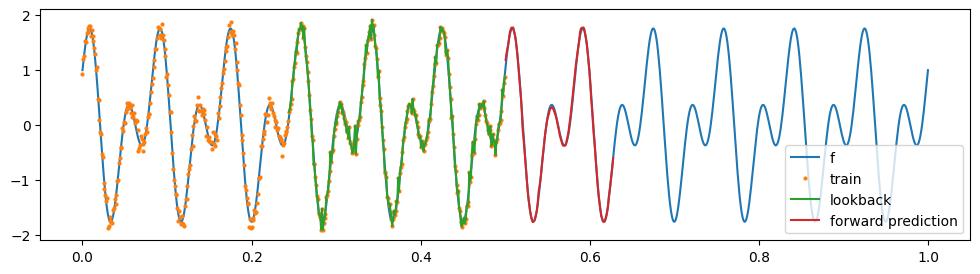

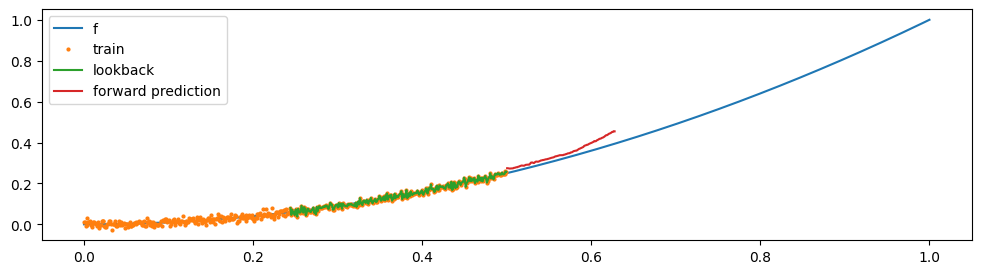

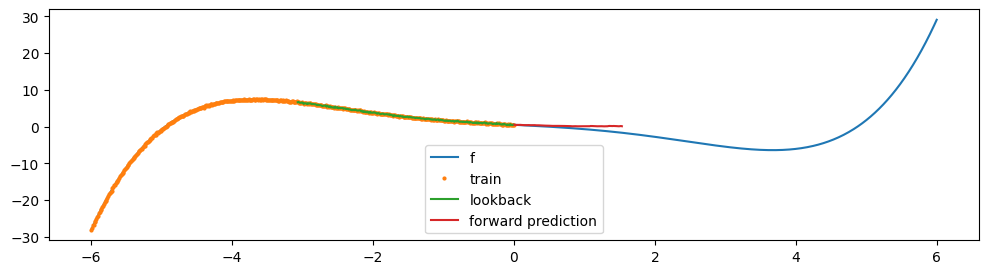

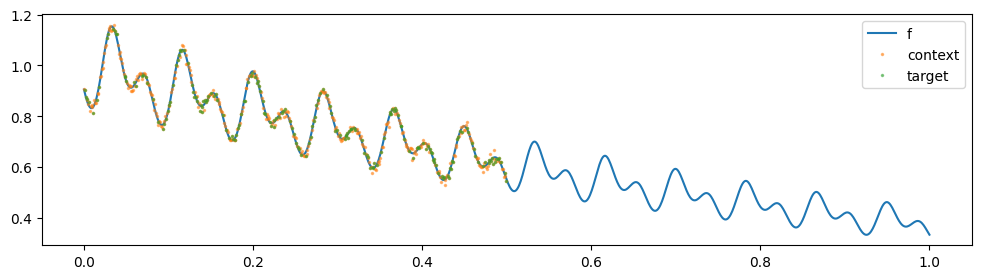

In [86]:
plt.figure(figsize=(12, 3))
idx = torch.randperm(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]
plt.plot(x_all.cpu(), f(x_all).cpu(), label="f")
plt.plot(x_train.cpu(), y_train.cpu(), '.', label="context", markersize=3, alpha=0.5)
plt.plot(x_train[-lookback_window:].cpu(), y_train[-lookback_window:].cpu(),'.', label="target", markersize=3, alpha=0.5)
plt.legend()